# Encoder-Decoder model for ENSO-forecasting

The Encoder-Decoder model is enspired by the architecture of autoencoders. Here, the size of the input layer of the neural network is the same size as the output layer. Furthermore, there is a so-called bottleneck layer present in the network which has less neurons than the input/output layers. For an Autoencoder the label and feature are the same. Because of the bottleneck layer, the network is forced to learn a lower dimesional expression of the input

For the Encoder-Decoder model (DEM), a time lag between the feature and the label is introduced. Such that the DEM is a forecast model. Hence, the DEM is forced to learn a lower dimensional expression that explains best the future state of the considered variable field.

<img src="AE_example.png" alt="Drawing" style="width: 400px;"/>

In this tutorial, the considered variable field is again the SST anomaly data from the ERSSTv5  data set.

## Read data 

In the following cell, we read the SST anoamly data that was computed in an earlier tutorial.

In [1]:
from ninolearn.IO.read_processed import data_reader

#read data
reader = data_reader(startdate='1959-11', enddate='2018-12')

# read SST data and directly make seasonal averages
SSTA = reader.read_netcdf('sst', dataset='ERSSTv5', processed='anom').rolling(time=3).mean()[2:]

# read the ONI for later comparison
oni = reader.read_csv('oni')[2:]

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Generate the feature and label arrays

The following cell generates the feature and label arrays. Because `feature` and `label` need to refer to an other object in the backend so that they can be changed without influencing each other.

Moreover, the data is scalled because this helps the DEM to be more precise.

In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# make deep copies of the sst data
feature = SSTA.copy(deep=True)
label = SSTA.copy(deep=True)

# reshape the data such that one time step is a 1-D vector
# i.e. the feature_unscaled array is hence 2-D (timestep, number of grid points)
feature_unscaled = feature.values.reshape(feature.shape[0],-1)
label_unscaled = label.values.reshape(label.shape[0],-1)

# scale the data
scaler_f = StandardScaler()
Xorg = scaler_f.fit_transform(feature_unscaled)

scaler_l = StandardScaler()
yorg = scaler_l.fit_transform(label_unscaled)

# replace nans with 0
Xall = np.nan_to_num(Xorg)
yall = np.nan_to_num(yorg)

# shift = 3 is needed to align with the usual way how lead time is defined
shift = 3

# the lead time
lead = 3

y = yall[lead+shift:]
X = Xall[:-lead-shift]
timey = oni.index[lead+shift:]

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/utils/extmath.py:688: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/utils/extmath.py:747: RuntimeWarning: invalid value encountered 

## Split the data set 

For the training and testing of machine learning models it is crucial to split the data set into:

1. __Train data set__ which is used to train the weights of the neural network

2. __Validation data set__ which is used to check for overfitting (e.g. when using early stopping) and to optimize the hyperparameters 

3. __Test data set__ which is used to to evaluate the trained model. 

__NOTE:__ It is important to understand that hyperparamters must be tuned so that the result is best for the Validation data set and __not__ for the test data set. Otherwise you can not rule out the case that the specific hyperparameter setting just works good for the specific test data set but is not generally a good hyperparameter setting.

In the following cell the train and the validation data set are still one data set, because this array will be later splitted into two arrays when th model is fitted.

In [3]:
test_indeces = test_indeces = (timey>='2001-01-01') & (timey<='2018-12-01')
train_val_indeces = np.invert(test_indeces)

train_val_X, train_val_y, train_val_timey = X[train_val_indeces,:], y[train_val_indeces,:], timey[train_val_indeces]
testX, testy, testtimey = X[test_indeces,:], y[test_indeces,:], timey[test_indeces]

## Fit the model

Let's train the model using a random search. This takes quite some time (for `n_iter=100` it took an hour on my local machine without GPU support). In this training process the train/validation data set will be splitted  In this example below this train/validation data is first divided into 5 segments (`n_segments=5`). One segment alwawys serves as the validation data set and the rest as training. Each segment is one time (`n_members_segment=1`) the validation data set. Hence, the ensemble consists in the end out of 5 models.

In [5]:
import keras.backend as K
from ninolearn.learn.models.encoderDecoder import EncoderDecoder

K.clear_session()

model = EncoderDecoder()

model.set_parameters(neurons=[(32, 8), (512, 64)], dropout=[0., 0.2], noise=[0., 0.5] , noise_out=[0., 0.5],
         l1_hidden=[0.0, 0.001], l2_hidden=[0.0, 0.001], l1_out=[0.0, 0.001], l2_out=[0.0, 0.001], batch_size=100,
         lr=[0.0001, 0.01], n_segments=5, n_members_segment=1, patience = 40, epochs=1000, verbose=0)

model.fit_RandomizedSearch(train_val_X, train_val_y, n_iter=10)


##################################################################
Search iteration Nr 1/10
##################################################################

Train member Nr 1/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00057: early stopping
97/97 [==============================] - 0s 275us/step
Loss: 0.5771286358538362
Train member Nr 2/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00069: early stopping
97/97 [==============================] - 0s 244us/step
Loss: 0.7397017011937407
Train member Nr 3/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping
97/97 [==============================] - 0s 244us/step
Loss: 0.5486227018931478
Train member Nr 4/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00043: early stopping
97/97 [========================

Restoring model weights from the end of the best epoch
Epoch 00168: early stopping
97/97 [==============================] - 0s 202us/step
Loss: 0.6584983191539332
Train member Nr 2/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00108: early stopping
97/97 [==============================] - 0s 194us/step
Loss: 1.1187939932665873
Train member Nr 3/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00083: early stopping
97/97 [==============================] - 0s 175us/step
Loss: 0.5672213100280958
Train member Nr 4/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00090: early stopping
97/97 [==============================] - 0s 278us/step
Loss: 0.5309555567416948
Train member Nr 5/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00279: early stopping
97/97 [======================

## Make predictions on the test data set

In [6]:
import xarray as xr

# make prediction
pred, pred_all_members = model.predict(testX)
test_label = scaler_l.inverse_transform(testy)

# reshape data into an xarray data array that is 3-D
pred_map = xr.zeros_like(label[lead+shift:,:,:][test_indeces])
pred_map.values = scaler_l.inverse_transform(pred).reshape((testX.shape[0], label.shape[1], label.shape[2]))

test_label_map = xr.zeros_like(label[lead+shift:,:,:][test_indeces])
test_label_map.values = test_label.reshape((testX.shape[0], label.shape[1], label.shape[2]))

# calculate the ONI
pred_oni = pred_map.loc[dict(lat=slice(-5, 5), lon=slice(190, 240))].mean(dim="lat").mean(dim='lon')

## Plot prediction for the ONI

In [7]:
import matplotlib.pyplot as plt
# Plot ONI Forecasts
plt.subplots(figsize=(8,1.8))

plt.plot(testtimey, pred_oni, c='navy')
plt.plot(testtimey, oni.loc[testtimey[0]: testtimey[-1]], "k")

plt.xlabel('Time [Year]')
plt.ylabel('ONI [K]')

plt.axhspan(-0.5, -6, facecolor='blue',  alpha=0.1,zorder=0)
plt.axhspan(0.5, 6, facecolor='red', alpha=0.1,zorder=0)

plt.xlim(testtimey[0], testtimey[-1])
plt.ylim(-3,3)

plt.title(f"Lead time: {lead} month")
plt.grid()

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


## Evaluate the seasonal skill for predicting the ONI

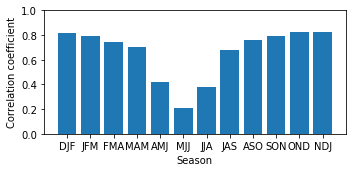

In [8]:
from ninolearn.plot.evaluation import plot_correlation
import pandas as pd

# make a plot of the seasonal correaltion
# note: - pd.tseries.offsets.MonthBegin(1) appears to ensure that the correlations are plotted
# agains the correct season

plot_correlation(oni.loc[testtimey[0]: testtimey[-1]], pred_oni, testtimey - pd.tseries.offsets.MonthBegin(1), title="")

## Check the correlations on a map

In the following the pearson correlation coefficent between the predicted and the observed value for each grid point are computed and afterwards plotted.

In [9]:
# rehshape predictions to a map
corr_map = np.zeros(pred.shape[1])

for j in range(len(corr_map)):
    corr_map[j] = np.corrcoef(pred[:,j], test_label[:,j])[0,1]
corr_map = corr_map.reshape((label.shape[1:]))

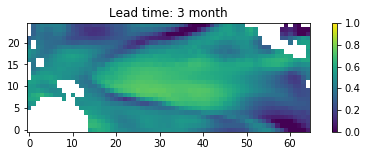

In [10]:
%matplotlib inline
# Plot correlation map
fig, ax = plt.subplots(figsize=(8,2))
plt.title(f"Lead time: {lead} month")
C=ax.imshow(corr_map, origin='lower', vmin=0, vmax=1)
cb=plt.colorbar(C)

## Animate the full test prediction

In [11]:
import matplotlib.animation as animation

def animation_ed(true, pred, nino,  nino_pred, time):
    fig, ax = plt.subplots(3, 1, figsize=(6,7), squeeze=False)

    vmin = -3
    vmax = 3

    true_im = ax[0,0].imshow(true[0], origin='lower', vmin=vmin, vmax=vmax, cmap=plt.cm.bwr)
    pred_im = ax[1,0].imshow(pred[0], origin='lower', vmin=vmin, vmax=vmax, cmap=plt.cm.bwr)
    title = ax[0,0].set_title('')

    ax[2,0].plot(time, nino)
    ax[2,0].plot(time, nino_pred)
    ax[2,0].set_ylim(-3,3)
    ax[2,0].set_xlim(time[0], time[-1])

    vline = ax[2,0].plot([time[0], time[0]], [-10,10], color='k')


    def update(data):
        true_im.set_data(data[0])
        pred_im.set_data(data[1])
        title_str = np.datetime_as_string(data[0].time.values)[:10]
        title.set_text(title_str)

        vline[0].set_data([data[2], data[2]],[-10,10])

    def data_gen():
        k = 0
        kmax = len(true)
        while k<kmax:

            yield true.loc[time[k]], pred.loc[time[k]], time[k]
            k+=1

    ani = animation.FuncAnimation(fig, update, data_gen, interval=100, repeat=True, save_count=len(true))
    plt.close("all")
    return ani

In [12]:
from IPython.display import HTML
ani = animation_ed(test_label_map, pred_map, 
                   oni.loc[testtimey[0]:testtimey[-1]], pred_oni, 
                   testtimey)

HTML(ani.to_html5_video())

So it looks like that the Encoder-Decoder ensemble has some skill. However, more research is needed to release the full potential of this model. 

Maybe you are interested working on this? :D